# Syllables Analysis & Derégnaucourt replication

This notebook contains statistical analyses done by Derégnaucourt et al. (2005). Our goal is to reproduce the results of this paper.

In [62]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import birdsonganalysis as bsa
from copy import deepcopy
from os.path import join, isdir, exists
import json
import pandas as pd
import pickle
from scipy.io import wavfile
from syllable_cluster import *

from ipywidgets.widgets import FloatProgress
from IPython.display import display

import sys

sys.path.append('../model')

from song_model import SongModel

sns.set_palette('colorblind')
%matplotlib inline

Extract the data from all the bird in the simulation.

In [72]:
import itertools
progress = FloatProgress(min=0, max=1)
display(progress)
main_path = '../model/res/diversity_weight/seed{}+big_ba+15_conc+3_day_conc+{}_diversity_weight+small_bloat_weight/'
all_dat = []

for seed, div in itertools.product(range(40), [1, 125, 10, 15, 2, 3]):
    if not isdir(main_path.format(seed, div)) or not exists(join(main_path.format(seed, div), 'data.pkl')):
        continue
    path = main_path.format(seed, div)
    cur_dat = syllables_from_run(path, force=False, progress=progress)
    cur_dat['bird'] = seed * 1000 + div
    cur_dat['div'] = div
    all_dat.append(cur_dat)
    seed += 1
all_dat = pd.concat(all_dat)

sr, tutor = wavfile.read(join(main_path.format(10, 1), 'tutor.wav'))
tutor_syllables = extract_syllables_statistics(tutor)

In [73]:
pad = 20


In [74]:
all_dat.keys()

Index(['beg', 'comb', 'day', 'end', 'isong', 'isyb', 'length', 'mam',
       'mamplitude', 'mentropy', 'mfm', 'mgoodness', 'moment', 'mpitch', 'vam',
       'vamplitude', 'ventropy', 'vfm', 'vgoodness', 'vpitch', 'run_name',
       'bird', 'div'],
      dtype='object')

# Study dynamics of syllable progression

In [75]:
all_dat['bird'].unique()

array([    1,   125,    10,    15,     2,     3,  1001,  1125,  1010,
        1015,  1002,  1003,  4001,  4125,  4010,  4015,  4002,  4003,
        5001,  5125,  5010,  5015,  5002,  5003,  8001,  8015, 10001,
       10125, 10010, 10015, 10002, 10003, 11003])

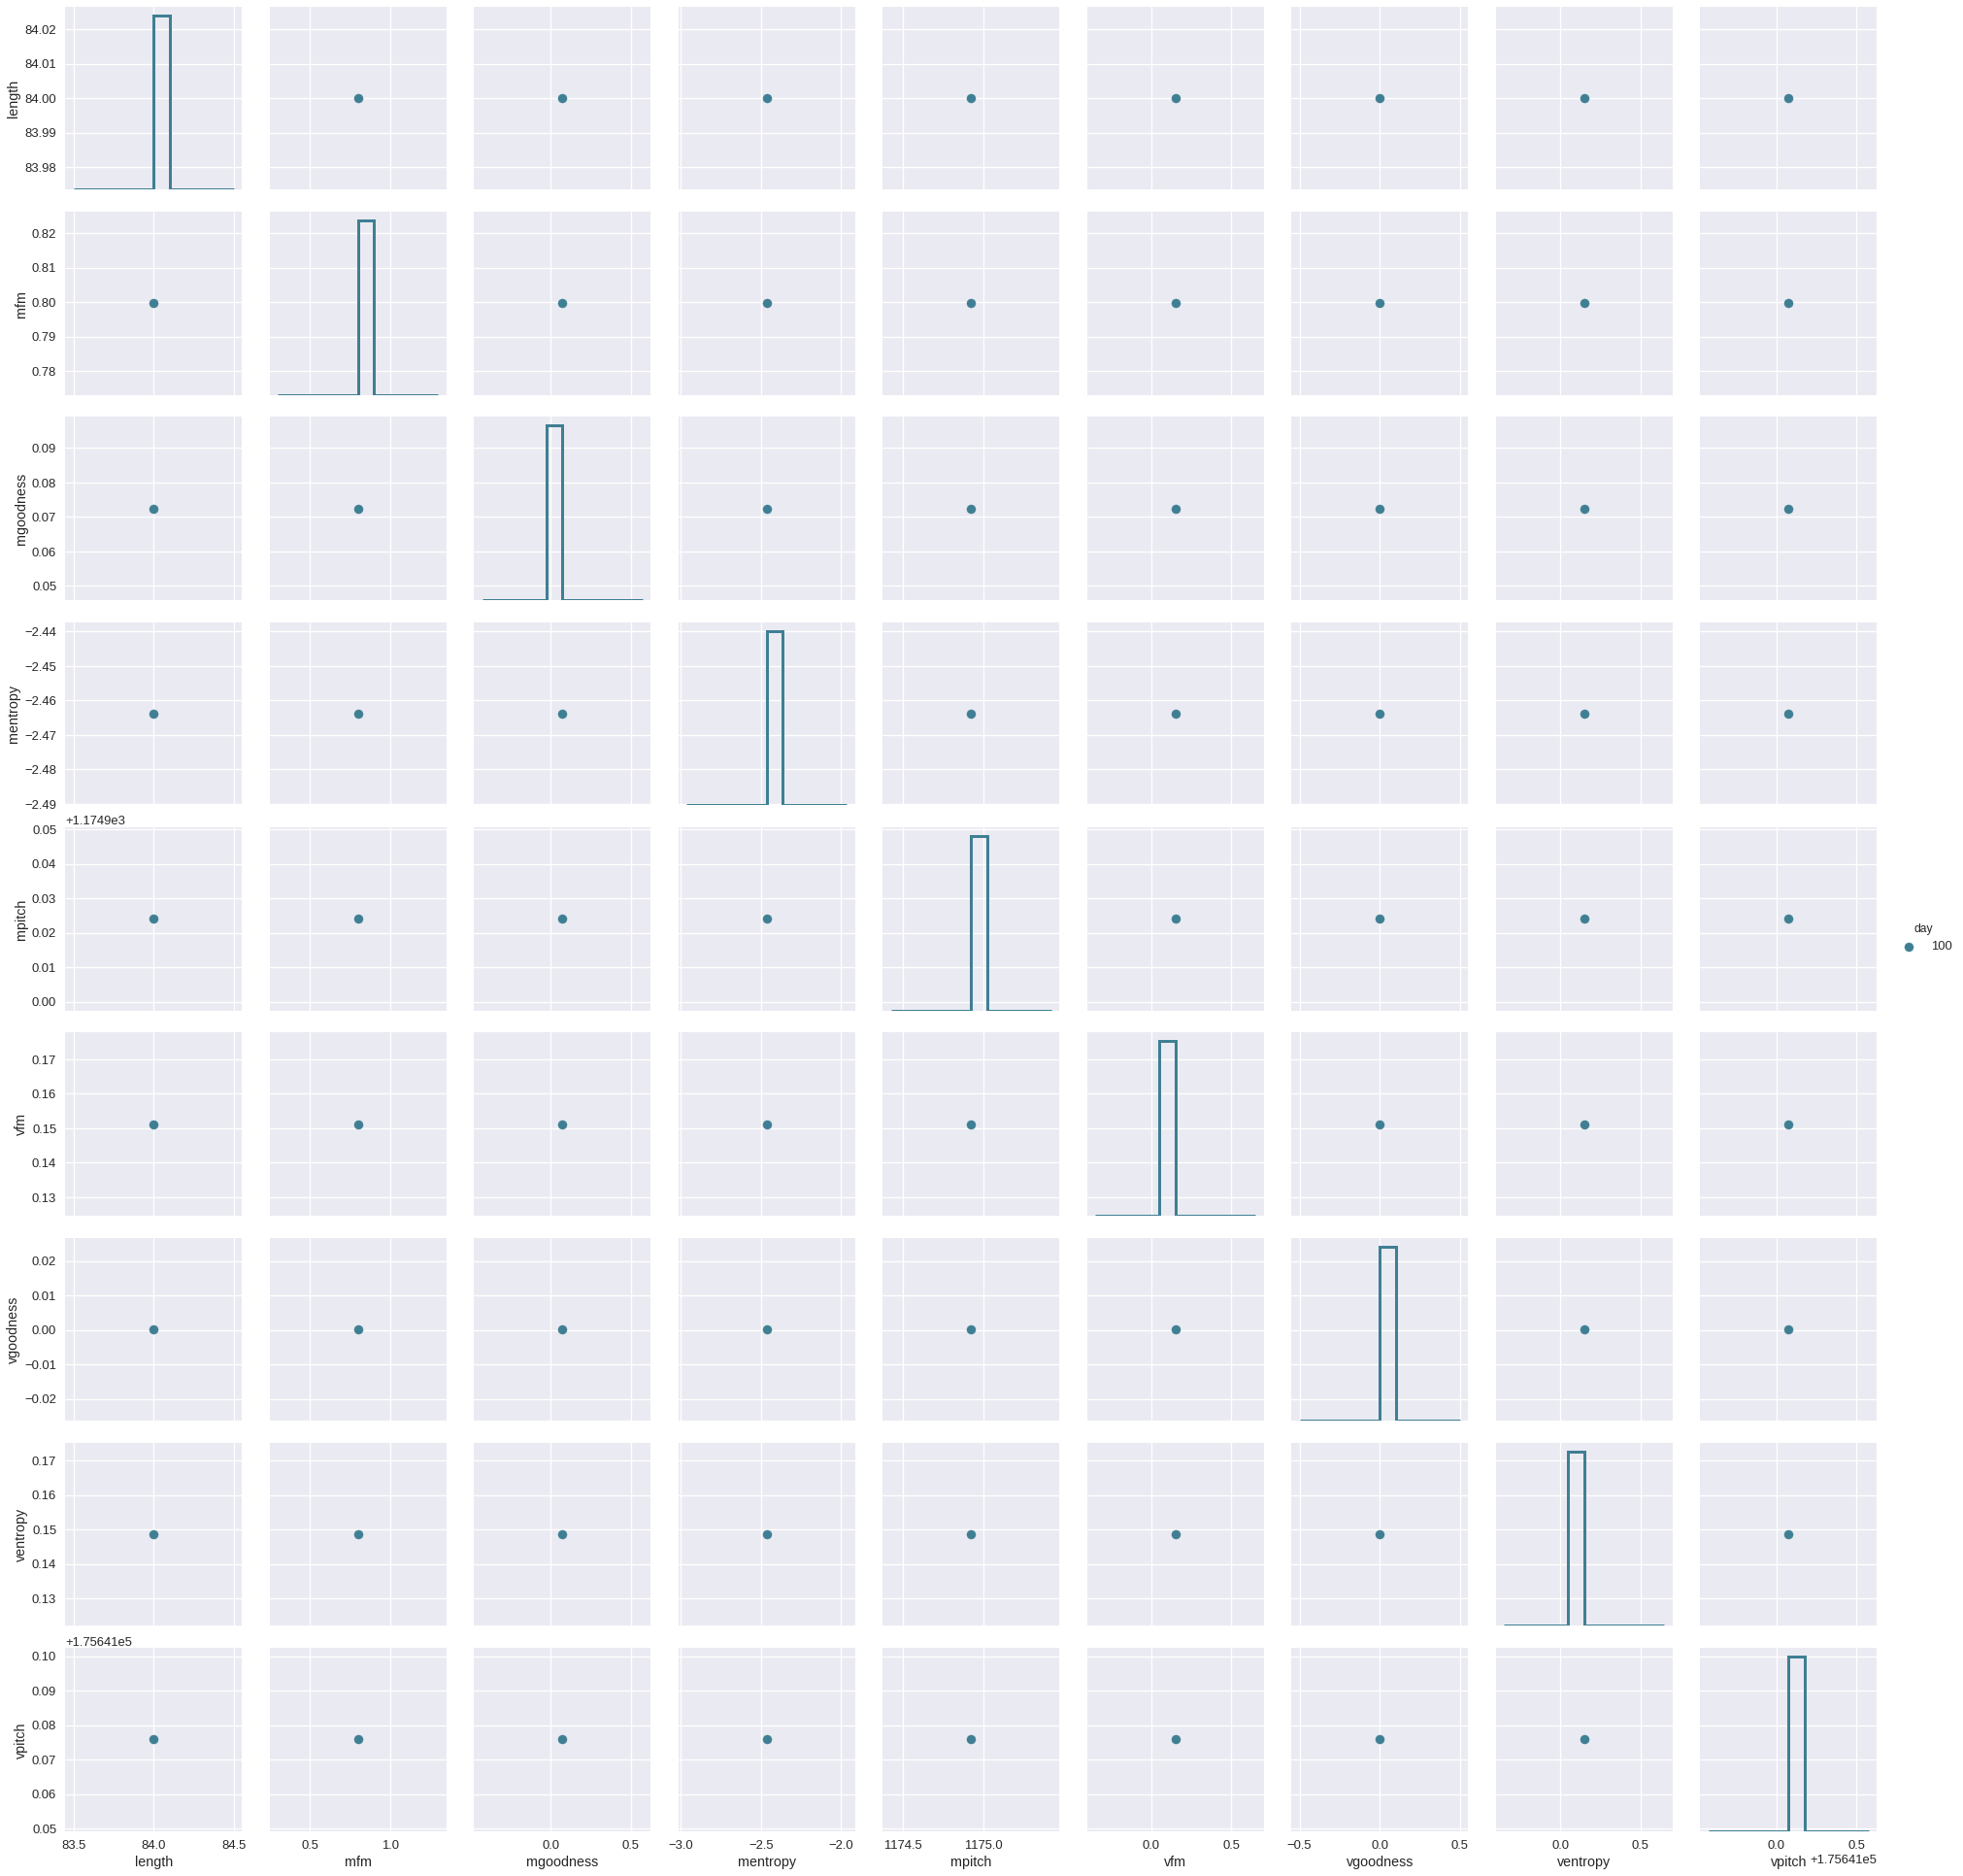

In [76]:
beg = tutor_syllables[0]['beg'] - pad
end = tutor_syllables[0]['end'] + pad
plot_dat = all_dat.query("((bird == {bird}) and (moment == 'evening') and ( \
                         (beg > {beg} and end < {end}) and day % 5 == 4))".format(
    bird=8002,
    beg=tutor_syllables[0]['beg'] - pad,
    end=tutor_syllables[0]['end'] + pad
))
tutor_df = pd.DataFrame(tutor_syllables)
tutor_df['day'] = 100
plot_dat = pd.concat((plot_dat, tutor_df.query("beg > {beg} and end < {end}".format(beg=beg, end=end))))

g = sns.PairGrid(plot_dat, hue="day", hue_kws={'marker': ['o'] * (50//5) + ['*']},
                 vars=['length', 'mfm', 'mgoodness', 'mentropy', 'mpitch',
                                            'vfm', 'vgoodness', 'ventropy', 'vpitch'], size=3, palette=sns.diverging_palette(220, 20, n=5))
g.map_diag(plt.hist, histtype="step", linewidth=3)
g.map_offdiag(plt.scatter, alpha=1)
#g.map_offdiag(sns.kdeplot, alpha=0.3)
g.add_legend()


/home/ecoffet/.virtualenvs/birdsongs/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


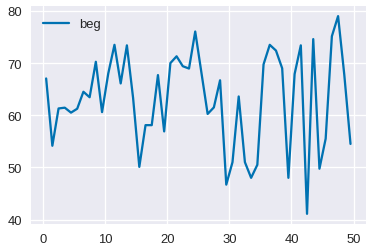

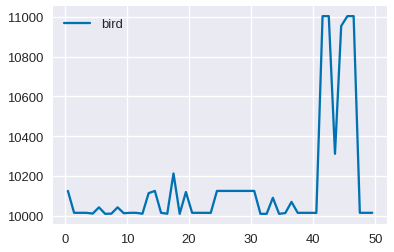

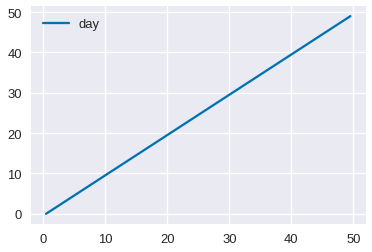

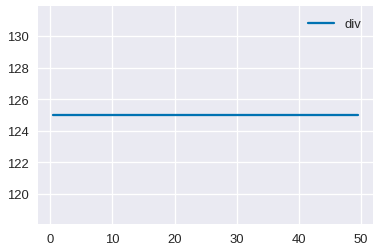

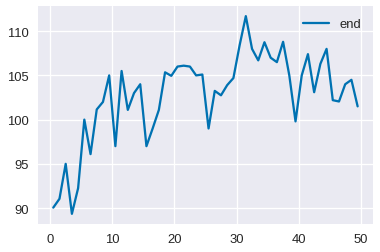

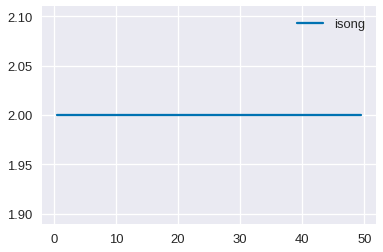

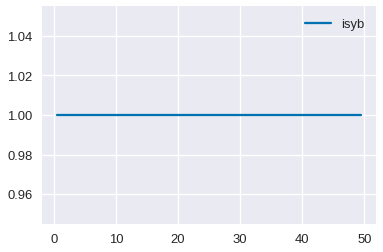

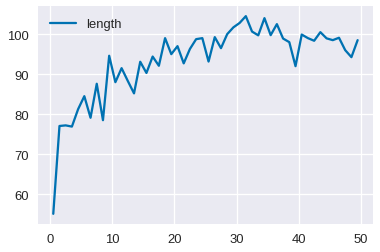

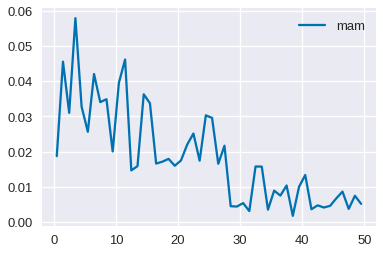

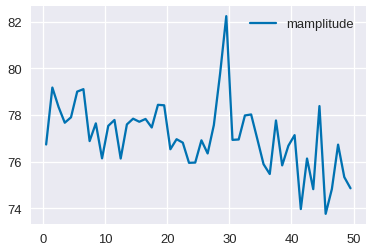

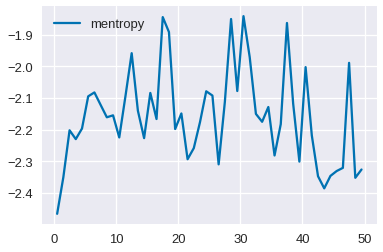

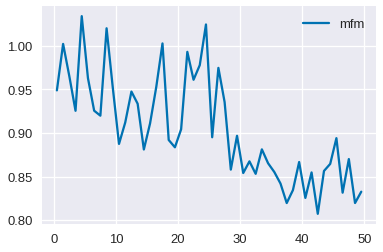

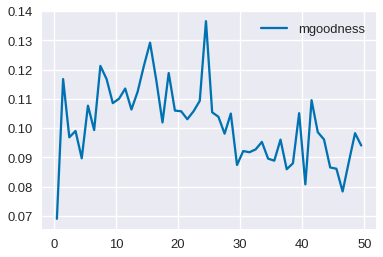

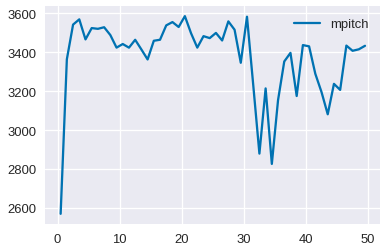

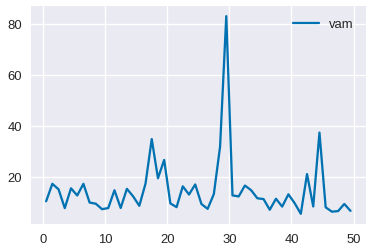

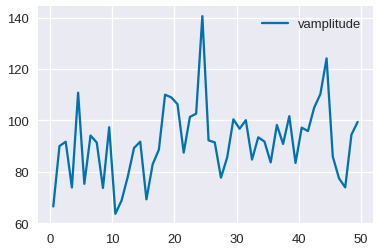

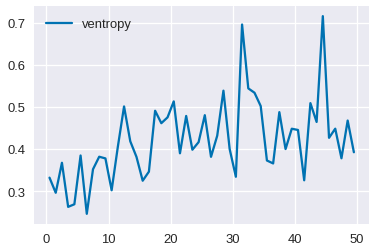

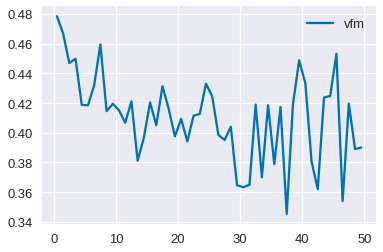

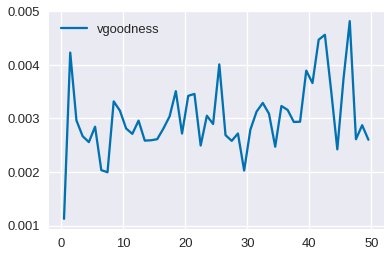

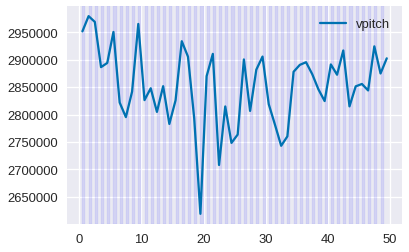

In [77]:
plt.figure(figsize=(14, 14))
med = all_dat.query('beg > {beg} and end < {end} and moment == "evening"'.format(
    beg=tutor_syllables[0]['beg'] - pad,
    end=tutor_syllables[0]['end'] + pad)).groupby('comb').quantile(0.95)
for item in med.keys():
    plt.figure()
    plt.plot(med[item], label=item)
    plt.legend()
for day in range(np.max(all_dat['day'])):
    plt.axvspan(day+0.5, day+1, color='b', alpha=0.1)

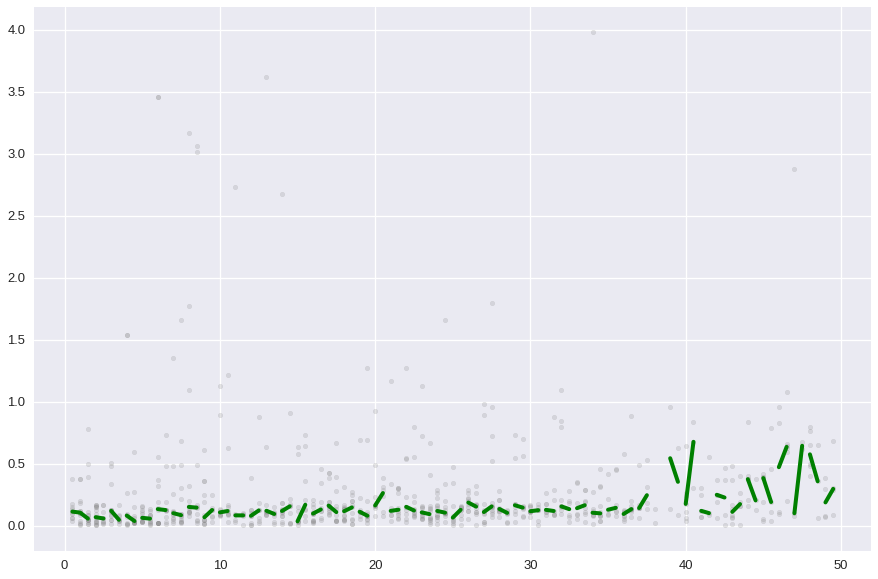

In [78]:
plt.figure(figsize=(15, 10))

feat = 'ventropy'

splitted = all_dat.query("isyb == 3 and div == 15").groupby('comb')[feat].quantile(0.5)
for i in splitted.index:
    if i % 1 == 0:
        splitted.set_value(i + 0.75, np.nan)
splitted.sort_index(inplace=True)


plt.scatter(all_dat.query("isyb == 3 and div == 15")['comb'], all_dat.query("isyb == 3 and div == 15")[feat], marker='.', alpha=0.2, color="grey")
plt.plot(splitted, linewidth=4, color="g")


In [79]:
splitted

comb
0.50     0.112268
1.00     0.104237
1.50     0.056270
1.75          NaN
2.00     0.067648
2.50     0.057012
2.75          NaN
3.00     0.118576
3.50     0.046249
3.75          NaN
4.00     0.080678
4.50     0.036350
4.75          NaN
5.00     0.062243
5.50     0.055728
5.75          NaN
6.00     0.132630
6.50     0.124900
6.75          NaN
7.00     0.099640
7.50     0.083950
7.75          NaN
8.00     0.150114
8.50     0.144506
8.75          NaN
9.00     0.066722
9.50     0.125223
9.75          NaN
10.00    0.106232
10.50    0.117114
           ...   
40.00    0.174356
40.50    0.675276
40.75         NaN
41.00    0.118462
41.50    0.100247
41.75         NaN
42.00    0.248073
42.50    0.225982
42.75         NaN
43.00    0.110419
43.50    0.173201
43.75         NaN
44.00    0.374042
44.50    0.203135
44.75         NaN
45.00    0.382674
45.50    0.189794
45.75         NaN
46.00    0.470690
46.50    0.634458
46.75         NaN
47.00    0.099542
47.50    0.643430
47.75         NaN
48.00

# Percent Change analysis

## Percent change absolute values

## Percent change signed values

In [80]:
all_changes = []

#features = ['mentropy', 'mfm','mgoodness','vfm','ventropy','vgoodness']
features = ['ventropy']

# NIGHT

for bird_n, bird in all_dat.groupby('bird'):
    print(bird_n)
    for isyb, syllable in tutor_df.iterrows():
        print('syb:', isyb)
        beg = syllable['beg'] - pad
        end = syllable['end'] + pad
        objective = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(bird['day'].max()-1, beg=beg, end=end))
        if len(objective) == 0:
            print(isyb, 'ignored')
            continue
        for day in range(bird['day'].max()):
            first = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(day, beg=beg, end=end))
            last  = bird.query('day == {} and moment == "morning" and beg > {beg} and end < {end}'.format(day+1, beg=beg, end=end))
            if len(first) > 0 and len(last) > 0:
                sign = np.sign(last.median() - first.median()) * np.sign(objective.median() - first.median())[features]
                #display(sign)
                percent_change_all = (sign * (((last.median() - first.median()) / first.median().abs() * 100).abs())[features])
                percent_change = percent_change_all.mean()
                    #print(percent_change_all)
                    #print(first['ventropy'])
                    #print(last['ventropy'])
                all_changes.append({'day': day, 'isyb': isyb, 'bird': bird_n, 'div': bird['div'].iloc[0], 'percent_change':percent_change, 'cond': 'night'})

# DAY
for bird_n, bird in all_dat.groupby('bird'):
    print(bird_n)
    for isyb, syllable in tutor_df.iterrows():
        print('syb:', isyb)
        beg = syllable['beg'] - pad
        end = syllable['end'] + pad
        objective = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(bird['day'].max()-1, beg=beg, end=end))
        if len(objective) == 0:
            print(isyb, 'ignored')
            continue
        for day in range(bird['day'].max()):
            first = bird.query('day == {} and moment == "morning" and beg > {beg} and end < {end}'.format(day, beg=beg, end=end))
            last  = bird.query('day == {} and moment == "evening" and beg > {beg} and end < {end}'.format(day, beg=beg, end=end))
            if len(first) > 0 and len(last) > 0:
                sign = np.sign(last.median() - first.median()) * np.sign(objective.median() - first.median())[features]
                #display(sign)
                percent_change_all = (sign * (((last.median() - first.median()) / first.median().abs() * 100).abs())[features])
                percent_change = percent_change_all.mean()
                all_changes.append({'day': day, 'isyb': isyb, 'div': bird['div'].iloc[0], 'bird': bird_n, 'percent_change':percent_change, 'cond': 'day'})


1
syb: 0
syb: 1
syb: 2
2
syb: 0
syb: 1
syb: 2
3
syb: 0
syb: 1
syb: 2
10
syb: 0
syb: 1
syb: 2
15
syb: 0
syb: 1
syb: 2
125
syb: 0
syb: 1
syb: 2
1001
syb: 0
syb: 1
syb: 2
2 ignored
1002
syb: 0
syb: 1
syb: 2
1003
syb: 0
syb: 1
syb: 2
1010
syb: 0
syb: 1
syb: 2
1015
syb: 0
syb: 1
syb: 2
1125
syb: 0
syb: 1
syb: 2
4001
syb: 0
syb: 1
syb: 2
4002
syb: 0
syb: 1
syb: 2
4003
syb: 0
syb: 1
syb: 2
4010
syb: 0
syb: 1
syb: 2
4015
syb: 0
syb: 1
syb: 2
4125
syb: 0
syb: 1
syb: 2
5001
syb: 0
syb: 1
syb: 2
5002
syb: 0
syb: 1
syb: 2
5003
syb: 0
syb: 1
syb: 2
5010
syb: 0
syb: 1
syb: 2
5015
syb: 0
syb: 1
syb: 2
5125
syb: 0
syb: 1
1 ignored
syb: 2
8001
syb: 0
0 ignored
syb: 1
syb: 2
8015
syb: 0
syb: 1
syb: 2
10001
syb: 0
syb: 1
syb: 2
10002
syb: 0
syb: 1
syb: 2
10003
syb: 0
syb: 1
syb: 2
10010
syb: 0
syb: 1
syb: 2
10015
syb: 0
syb: 1
syb: 2
10125
syb: 0
0 ignored
syb: 1
syb: 2
11003
syb: 0
syb: 1
syb: 2
1
syb: 0
syb: 1
syb: 2
2
syb: 0
syb: 1
syb: 2
3
syb: 0
syb: 1
syb: 2
10
syb: 0
syb: 1
syb: 2
15
syb: 0
syb: 1

In [81]:
change_df = pd.DataFrame(all_changes)
change_df["birdsyb"] = change_df['bird'] * 1000 + change_df['isyb']

change_df = change_df.groupby(('day', 'bird', 'cond')).mean()

change_df = pd.DataFrame(change_df.to_records())


In [82]:
change_df.groupby(('day', 'bird', 'cond')).mean()

div  isyb  percent_change     birdsyb
day bird  cond                                          
0   1     day      1.0   0.5     9933.157997      1000.5
          night    1.0   1.0       -1.802810      1001.0
    2     day      2.0   0.5    25285.449369      2000.5
          night    2.0   1.0     -110.826203      2001.0
    3     day      3.0   0.5     6033.366231      3000.5
          night    3.0   1.0      -10.052944      3001.0
    10    day     10.0   0.5     9560.967301     10000.5
          night   10.0   1.0       29.221247     10001.0
    15    day     15.0   0.5    17108.818499     15000.5
          night   15.0   1.0        2.999370     15001.0
    125   day    125.0   0.5    12719.832003    125000.5
          night  125.0   1.0       -4.835287    125001.0
    1001  day      1.0   0.5     2902.500736   1001000.5
          night    1.0   0.5       32.222376   1001000.5
    1002  day      2.0   0.5    13827.909797   1002000.5
          night    2.0   1.0       -2.874713   1002001.0
    1003  day      3.0   0.5    45677.288268   1003000.5
          night    3.0   1.0      -14.490360   1003001.0
    1010  day     10.0   0.5    10350.363234   1010000.5
          night   10.0   1.0       -6.982330   1010001.0
    1015  day     15.0   0.5    11531.467871   1015000.5
          night   15.0   1.0      -41.648273   1015001.0
    1125  day    125.0   0.5     7981.066633   1125000.5
          night  125.0   1.5      -91.654645   1125001.5
    4001  day      1.0   0.5     6324.565482   4001000.5
          night    1.0   1.0      180.336053   4001001.0
    4002  day      2.0   0.5    12251.859433   4002000.5
          night    2.0   1.5      -37.143723   4002001.5
    4003  day      3.0   0.5     4386.270434   4003000.5
          night    3.0   1.0       -8.058822   4003001.0
...                ...   ...             ...         ...
48  1125  day    125.0   1.0       16.113010   1125001.0
          night  125.0   1.0        0.000000   1125001.0
    4001  day      1.0   1.0       24.048216   4001001.0
          night    1.0   1.0        0.000000   4001001.0
    4002  day      2.0   1.0       25.328347   4002001.0
          night    2.0   1.0        0.000000   4002001.0
    4003  day      3.0   1.0       23.232438   4003001.0
          night    3.0   1.0        0.000000   4003001.0
    4010  day     10.0   1.0       13.630386   4010001.0
          night   10.0   1.0        0.000000   4010001.0
    4015  day     15.0   1.0       41.081997   4015001.0
          night   15.0   1.0        0.000000   4015001.0
    4125  day    125.0   1.0       80.378671   4125001.0
          night  125.0   1.0        0.000000   4125001.0
    8015  day     15.0   1.0        7.569764   8015001.0
          night   15.0   1.0        0.000000   8015001.0
    10001 day      1.0   1.0      293.325705  10001001.0
          night    1.0   1.5        0.000000  10001001.5
    10002 day      2.0   1.5       67.633836  10002001.5
          night    2.0   1.0        0.000000  10002001.0
    10003 day      3.0   1.0       27.813950  10003001.0
          night    3.0   1.0        0.000000  10003001.0
    10010 day     10.0   1.0       18.002782  10010001.0
          night   10.0   1.0        0.000000  10010001.0
    10015 day     15.0   1.0       91.705647  10015001.0
          night   15.0   1.0        0.000000  10015001.0
    10125 day    125.0   1.5       58.963448  10125001.5
          night  125.0   1.5        0.000000  10125001.5
    11003 day      3.0   1.0       50.461778  11003001.0
          night    3.0   1.0        0.000000  11003001.0

[3061 rows x 4 columns]

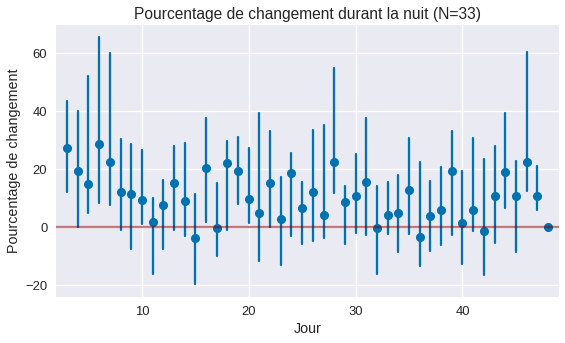

In [96]:
%matplotlib inline
sns.set_context('talk')
plt.figure(figsize=(9, 5))
ax = sns.tsplot(change_df.query('day > 2 and cond=="night"'), time='day', unit='bird', interpolate=False, condition='cond', value='percent_change', err_style='ci_bars', ci=95, estimator=np.nanmedian)
plt.axhline(0, c='darkred', alpha=0.5)
plt.ylabel("Pourcentage de changement")
plt.xlabel('Jour')
ax.legend([])
plt.title('Pourcentage de changement durant la nuit (N={})'.format(len(change_df['bird'].unique())))


In [84]:
all_changes_df = pd.DataFrame(all_changes)
night_pc = change_df.query('cond == "night" and day > 2').groupby('bird').mean()

In [85]:
night_pc

,day,div,isyb,percent_change,birdsyb
bird,,,,,
1,25.500000,1.0,0.978261,49.526813,1.000978e+03
2,25.500000,2.0,0.934783,43.785386,2.000935e+03
3,25.500000,3.0,1.000000,19.008744,3.001000e+03
10,25.500000,10.0,0.750000,-6.825406,1.000075e+04
15,25.500000,15.0,0.891304,255.470908,1.500089e+04
125,25.500000,125.0,0.782609,9.909467,1.250008e+05
1001,25.500000,1.0,0.489130,3.801221,1.001000e+06
1002,25.500000,2.0,0.967391,8.999834,1.002001e+06
1003,25.500000,3.0,1.065217,31.137538,1.003001e+06


In [86]:
force = True
try:
    sim
except:
    force = True
if force:
    sim = []
    for bird in night_pc.index:
        i = bird//1000
        div = bird%1000
        try:
            with open(join(main_path.format(i, div), 'data_cur.pkl'), 'rb') as f:
                songlog = pickle.load(f)
        except FileNotFoundError:
            continue
        root_data = [item[1] for item in songlog if item[0] == 'root']
        rd = pd.DataFrame(root_data)
        smodels = rd['songs'].iloc[-1]
        print(i, div, 'beg')
        sim.append(bsa.similarity(smodels[np.argmin(rd['scores'].iloc[-1])].gen_sound(), tutor)['similarity'])
        print(i)

0 1 beg
0
0 2 beg
0
0 3 beg
0
0 10 beg
0
0 15 beg
0
0 125 beg
0
1 1 beg
1
1 2 beg
1
1 3 beg
1
1 10 beg
1
1 15 beg
1
1 125 beg
1
4 1 beg
4
4 2 beg
4
4 3 beg
4
4 10 beg
4
4 15 beg
4
4 125 beg
4
5 1 beg
5
5 2 beg
5
5 3 beg
5
5 10 beg
5
5 15 beg
5
5 125 beg
5
8 1 beg
8
8 15 beg
8
10 1 beg
10
10 2 beg
10
10 3 beg
10
10 10 beg
10
10 15 beg
10
10 125 beg
10
11 3 beg
11


In [87]:
night_pc['percent_change_deterioration'] = -night_pc['percent_change']

night_pc['sim'] = sim

<IPython.core.display.Javascript object>


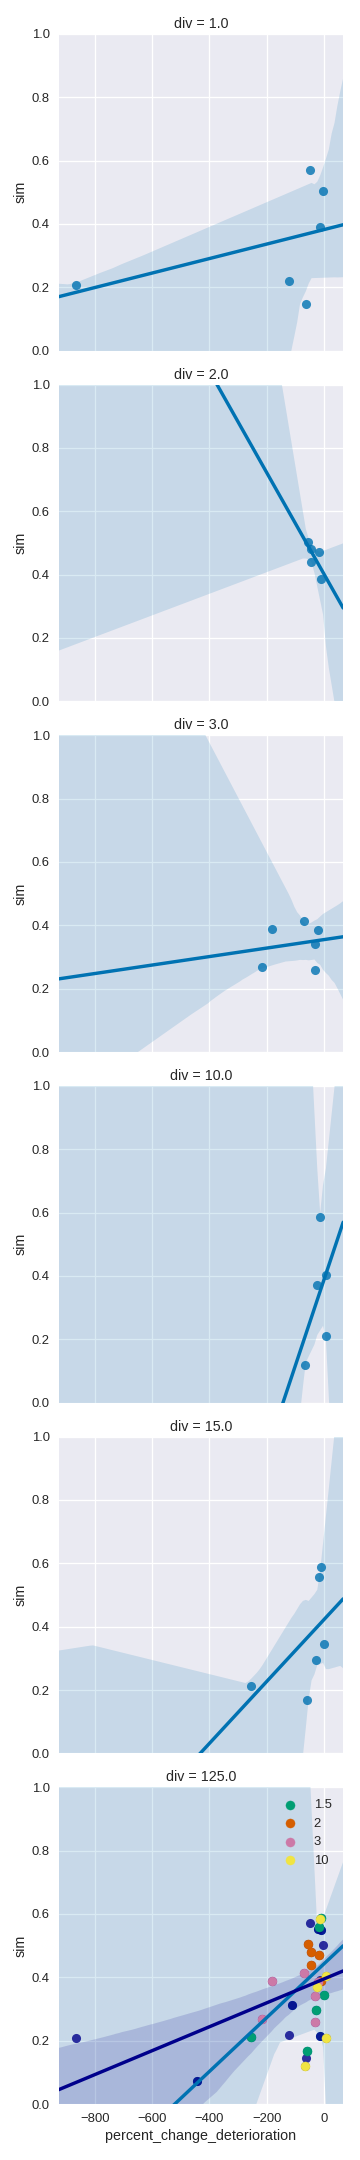

(0, 1)

In [88]:

sns.lmplot(x="percent_change_deterioration", y='sim', row='div', data=night_pc, ci=95)
plt.ylim((0, 1))

In [89]:
from scipy import stats

In [99]:
stats.linregress(night_pc['percent_change_deterioration'], night_pc['sim'])

LinregressResult(slope=0.00037653543932095722, intercept=0.39454559165849035, rvalue=0.42653631348147064, pvalue=0.013311407698789145, stderr=0.00014340469722238719)

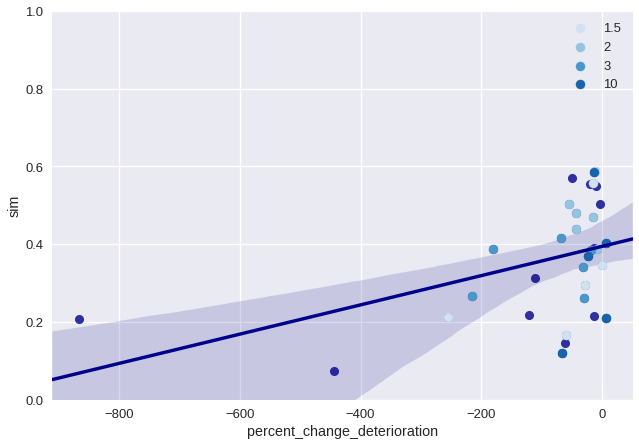

In [98]:
with sns.color_palette('Blues', 4):
    ax = sns.regplot(x="percent_change_deterioration", y='sim', data=night_pc, ci=95, color="darkblue")
    plt.figure(figsize=(8, 8))
    ax.set_ylim((0, 1))
    for i, div in enumerate([15, 2, 3, 10]):
        if div > 10:
            div_s = div / 10
        else:
            div_s = div
        ax.scatter(night_pc.query('div == {}'.format(div))['percent_change_deterioration'], list(night_pc.query('div == {}'.format(div))['sim']), label=div_s)
    ax.legend()